100%|██████████| 2948/2948 [00:06<00:00, 476.27it/s]


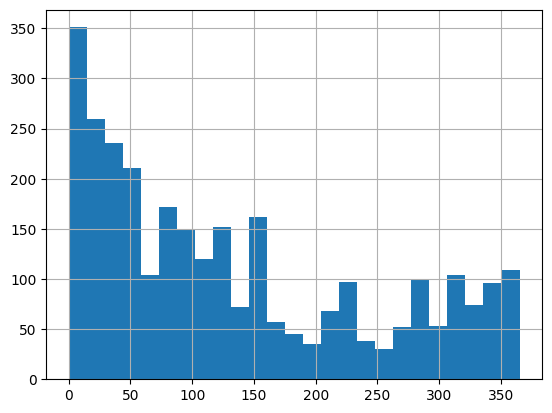

In [1]:
import pandas as pd
import datetime

from mandrill.dataset import read_dataset, ClassificationMandrillImageDataset, filter_by_qty

max_age = 1
max_days = 365 * max_age

dataset_path = "MFD_metadatas.csv"

data = read_dataset(dataset_path, filter_dob_error=True, filter_certainty=True, max_age=max_days)
hist = data["age"].hist(bins=25)

n_classes = 12
class_step = 365 / n_classes
name = f"exp_classif_{n_classes}"

dataset = ClassificationMandrillImageDataset(root_dir='Images', dataframe=data, in_mem=True, n_classes=n_classes, days_step=class_step)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.models import resnet18
from torchmetrics.classification import Accuracy 
import cv2
import os
from tqdm import tqdm
import numpy as np

from mandrill.models import InceptionResnetV1, RegressionModel, VGGFace
from mandrill.utils import split_dataset, load, save

learning_rate = 1e-4
batch_size = 32
num_epochs = 100
train_ratio = 0.8
val_ratio = 0.2

torch.manual_seed(0)
train_loader, val_loader, train_dataset, val_dataset = split_dataset(dataset, train_ratio, batch_size, augment=False)

# Model
# backbone = InceptionResnetV1()
backbone = VGGFace()
model = RegressionModel(backbone, input_dim=backbone.output_dim, output_dim=n_classes, sigmoid=False, n_lin=6, lin_start=2048)

# Loss function
criterion = nn.CrossEntropyLoss()
#val_criterion = nn.CrossEntropyLoss()
val_criterion = Accuracy(task="multiclass", num_classes=n_classes)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
backbone = backbone.to(device)
model = model.to(device)
val_criterion = val_criterion.to(device)

train = False

model = load(model, "classif", exp_name=name)

if train:
    # Training loop
    best_val = 0.0
    for epoch in range(num_epochs):
        model.train()  # Set the model to train mode
        train_loss = 0.0

        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)

        train_loss /= len(train_dataset)

        # Validation loop
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0

        with torch.no_grad():
            for images, labels in tqdm(val_loader):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                
                outputs = torch.argmax(outputs, dim=-1)
                labels = torch.argmax(labels, dim=-1)
                
                loss = val_criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)

        val_loss /= len(val_dataset)

        if val_loss > best_val:
            print(f"Val loss improved from {best_val:.4f} to {val_loss:.4f}")
            best_val = val_loss
            save(model, "classif", exp_name=name)
        else:
            print(f"Val loss did not improved from {best_val:.4f}")    


        # Print training and validation metrics
        print(f"Epoch [{epoch+1}/{num_epochs}] - "
              f"Train Loss: {train_loss:.4f} - "
              f"Val accuracy: {val_loss:.4f}")
print("Training done")

Using device: cuda
Training done


In [3]:
import matplotlib.pyplot as plt
import numpy as np

from mandrill.utils import load, softmax

model = load(model, "classif", exp_name=name)

val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

max_display = 0

y_true = []
y_pred = []

model.eval()

# Perform inference on validation images
for i, (images, targets) in tqdm(enumerate(val_loader)):
    # Forward pass
    images = images.to(device)
    outputs = model(images)
    
    # Convert the outputs to numpy arrays
    output_prob = softmax(outputs.squeeze().detach().cpu().numpy())
    predicted_class = np.argmax(output_prob)

    real_class = np.argmax(targets.squeeze().cpu().numpy())
    
    y_true.append(real_class)
    y_pred.append(output_prob)
    
    if i >= max_display:
        continue
    
    # Display the results
    print("Predicted class:", predicted_class)
    print("Real class:", real_class)
    print()  # Add an empty line for separation
    
    # Visualize the images and predictions
    plt.imshow(images.squeeze().cpu().permute(1, 2, 0))
    plt.title(f"Predicted: {predicted_values}, Actual: {actual_values}")
    plt.show()

590it [00:08, 65.89it/s]


Accuracy: 0.7169
Precision: 0.6643
Recall: 0.6526
F1-score: 0.6508


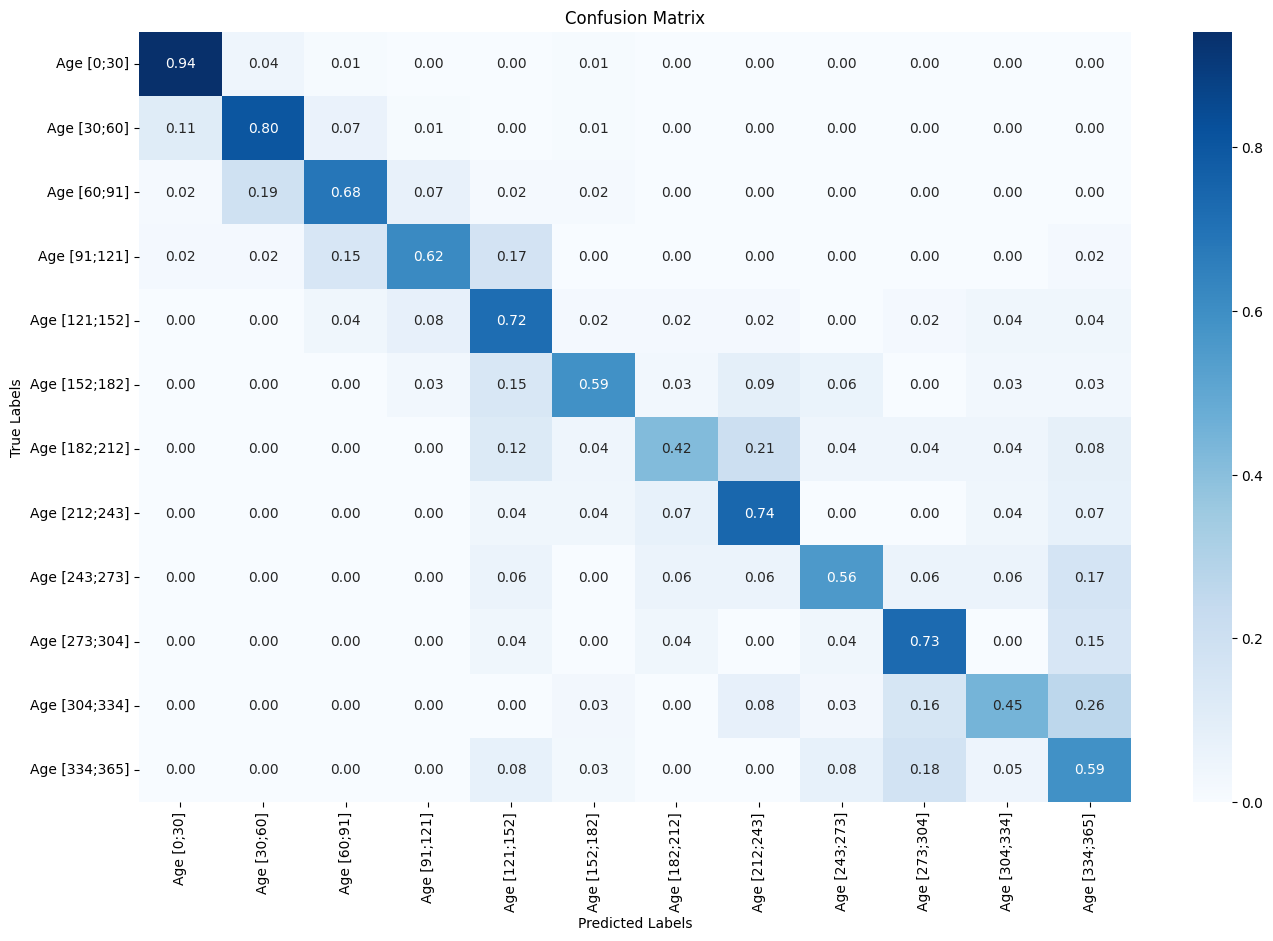

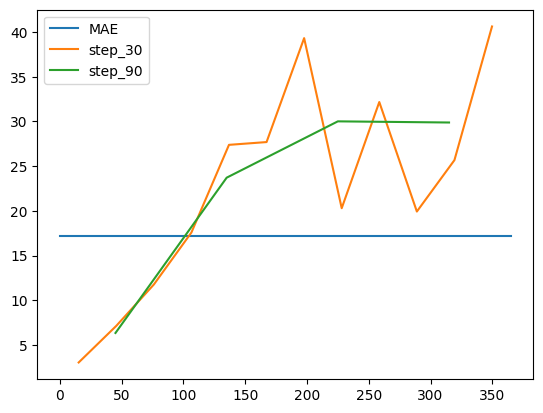

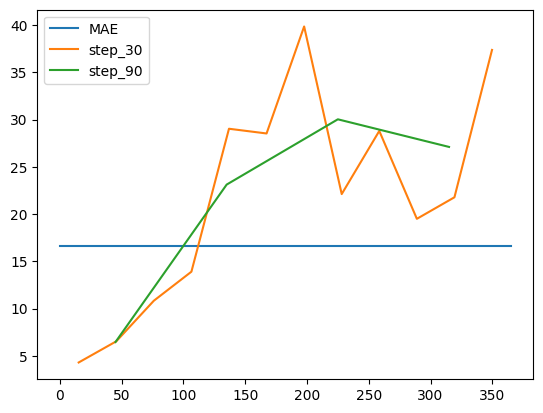

{'vgg_face_half_month': {'vgg_face_half_month_as_regression': {'argmax': {'vgg_face_half_month_as_regression_mae': 17.223728813559323,
    'vgg_face_half_month_as_regression_mae_steps': {30.416666666666668: [(15.208333333333334,
       3.046218487394958),
      (45.625, 7.136792452830188),
      (76.04166666666667, 11.763157894736842),
      (106.45833333333334, 17.576923076923077),
      (136.875, 27.38),
      (167.29166666666669, 27.691176470588236),
      (197.70833333333334, 39.3125),
      (228.125, 20.296296296296298),
      (258.5416666666667, 32.166666666666664),
      (288.95833333333337, 19.923076923076923),
      (319.375, 25.67105263157895),
      (349.7916666666667, 40.61538461538461)],
     90: [(45.0, 6.345744680851064),
      (135.0, 23.709558823529413),
      (225.0, 30.007246376811594),
      (315.0, 29.87864077669903)]}},
   'weighted_scalars': {'vgg_face_half_month_as_regression_mae': 16.663953946323016,
    'vgg_face_half_month_as_regression_mae_steps': {30.416666

In [4]:
from mandrill.evaluations import standard_classification_evaluation
standard_classification_evaluation(y_true, y_pred, class_step, n_classes, "vgg_face_one_month")